# Froude number estimates

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import munch
import utils
import glob

Load data.

In [2]:
# Towyos separate
data_files = glob.glob("../proc_data/TY*.mat")
TYs = np.asarray([munch.munchify(utils.loadmat(file)) for file in data_files])
P5TYs = [TY for TY in TYs if ((TY.sill == "P5") and (TY.year == 2014))]
# Bathymetry
bathy = xr.open_dataset("../raw_data/merged_200_-171.5_-167.5_-11_-6.5.nc")
bathyP5 = bathy.isel(lon=(bathy.lon < -168.5) & (bathy.lon > -168.8), lat=(bathy.lat > -8.3) & (bathy.lat < -7.9))
# Towyos together
ds = xr.open_dataset("../proc_data/stacked_towyos.nc")
ds

<xarray.Dataset>
Dimensions:      (pfl: 614, z: 1401)
Coordinates:
  * z            (z) float64 -3.9e+03 -3.901e+03 ... -5.299e+03 -5.3e+03
  * pfl          (pfl) int64 0 1 2 3 4 5 6 7 ... 606 607 608 609 610 611 612 613
    lon          (pfl) float64 ...
    lat          (pfl) float64 ...
    x            (pfl) float64 ...
    y            (pfl) float64 ...
Data variables:
    T            (z, pfl) float64 ...
    S            (z, pfl) float64 ...
    CT           (z, pfl) float64 ...
    SA           (z, pfl) float64 ...
    u            (z, pfl) float64 ...
    v            (z, pfl) float64 ...
    sig4         (z, pfl) float64 ...
    sig4_sorted  (z, pfl) float64 ...
    b            (z, pfl) float64 ...
    b_sorted     (z, pfl) float64 ...
    eps          (z, pfl) float64 ...
    LT           (z, pfl) float64 ...
    Lo           (z, pfl) float64 ...
    N2_overturn  (z, pfl) float64 ...
    N2_ref       (z, pfl) float64 ...

Single layer Froude number,

\begin{equation}
Fr = \frac{U}{\sqrt{g'h}},
\end{equation}

with,

\begin{equation}
g' = \frac{\Delta \sigma_4}{\overline{\sigma_4}},
\end{equation}

with,

\begin{equation}
\Delta \sigma_4 = \sigma_4(z=zi-\delta z) - \sigma_4(z=z_i),
\end{equation}

where we define $z_i$ as the height of the interface and $\delta z$ as a smallish distance.

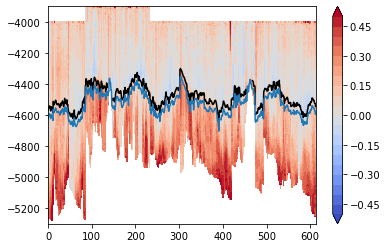

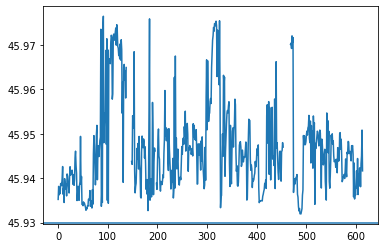

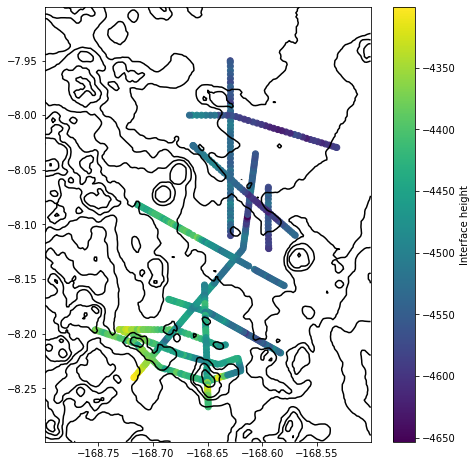

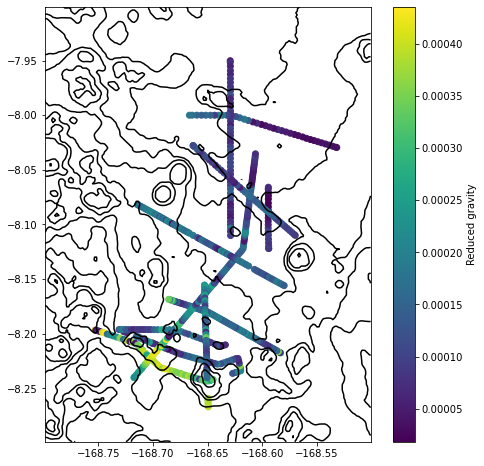

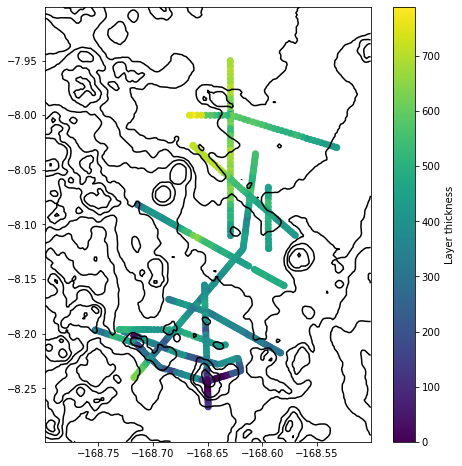

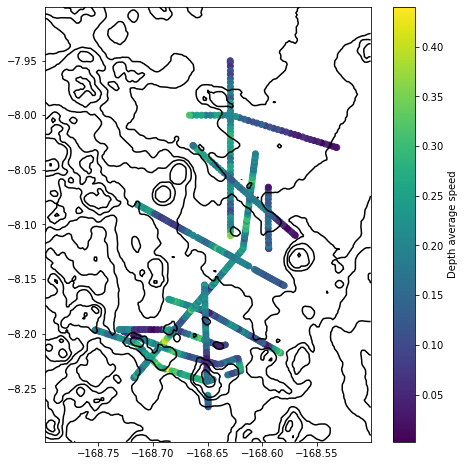

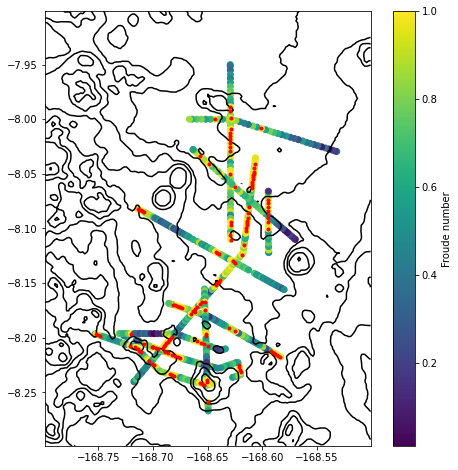

In [3]:
# define the density differene using a fixed distance from the isopycnal height
sig4i = 1045.93
sig4bar = 1045.9
dz = 50  # distance from 'interface top'
g = 9.81

# tile z grid for convenience
zg = np.tile(ds.z.values[:, np.newaxis], (1, ds.pfl.size))

# interface height
zi = utils.nan_interp(sig4i, ds.sig4_sorted.values, zg, axis=0)

# density distance dz below the interface
sig4dz = np.full_like(zi, np.nan)
for pfl in ds.pfl:
    sig4dz[pfl] = ds.sig4_sorted.isel(pfl=pfl).interp(z=zi[pfl]-dz)

dsig4 = sig4dz - sig4i
# reduced gravity
gp = g*dsig4/sig4bar

# overflow average velocity
inlayer = ds.sig4_sorted > sig4i
# depths within layer
zo = ds.z.where(inlayer)
# thickness
H = inlayer.sum("z")
# Can use sum to integrate because measurements every 1 m in towyos.
uo = ds.u.where(inlayer).sum("z")/H
vo = ds.v.where(inlayer).sum("z")/H
# Velocity for single layer estimate
U = np.sqrt(uo**2 + vo**2)
# Froude number
Fr = U/np.sqrt(gp*H)

fig, ax = plt.subplots()
CF = ax.contourf(ds.pfl, ds.z, ds.v, np.arange(-0.5, 0.55, 0.05), cmap="coolwarm", extend="both")
ax.contour(ds.pfl, ds.z, ds.sig4_sorted, [sig4i], colors="k")
ax.plot(ds.pfl, zi - dz)
plt.colorbar(CF)

fig, ax = plt.subplots()
ax.plot(ds.pfl, sig4dz - 1000)
ax.axhline(sig4i - 1000)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
CS = ax.scatter(ds.lon, ds.lat, c=zi)
cb = plt.colorbar(CS)
cb.set_label("Interface height")

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
CS = ax.scatter(ds.lon, ds.lat, c=gp)
cb = plt.colorbar(CS)
cb.set_label("Reduced gravity")

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
CS = ax.scatter(ds.lon, ds.lat, c=H)
cb = plt.colorbar(CS)
cb.set_label("Layer thickness")

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
CS = ax.scatter(ds.lon, ds.lat, c=U)
cb = plt.colorbar(CS)
cb.set_label("Depth average speed")

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
CS = ax.scatter(ds.lon, ds.lat, c=Fr, vmax=1.)
ax.plot(ds.lon[Fr > 1], ds.lat[Fr > 1], 'r.')
# CS = ax.scatter(ds.lon, ds.lat, c=Fr)
cb = plt.colorbar(CS)
cb.set_label("Froude number")

(array([11., 19., 41., 50., 86., 98., 85., 60., 41., 32., 19., 16., 13.,
         3.,  8.,  3.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
        1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
        2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ]),
 <BarContainer object of 24 artists>)

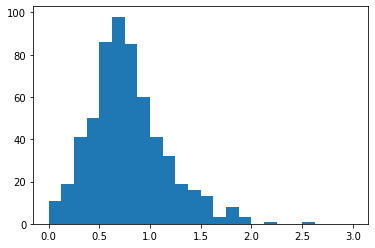

In [4]:
fig, ax = plt.subplots()
ax.hist(Fr, bins=np.linspace(0, 3, 25))

## Presence of large overturns

<ipython-input-49-bddb5d7a0577>:13: RuntimeWarning: invalid value encountered in true_divide
  frac = (h/n).T


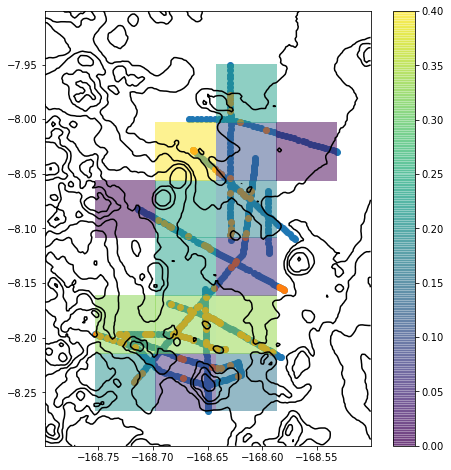

In [49]:
Lo = (ds.LT > 50).any(dim="z")

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")
ax.scatter(ds.lon, ds.lat)
ax.scatter(ds.lon[Lo], ds.lat[Lo])

binlon = np.linspace(ds.lon.min(), ds.lon.max(), 5)
binlat = np.linspace(ds.lat.min(), ds.lat.max(), 7)
h, _, _ = np.histogram2d(ds.lon, ds.lat, bins=[binlon, binlat], weights=Lo, density=False)
n, _, _ = np.histogram2d(ds.lon, ds.lat, bins=[binlon, binlat], density=False)
frac = (h/n).T
frac[n.T < 10] = np.nan

C = ax.pcolormesh(binlon, binlat, frac, alpha=0.5)
plt.colorbar(C)
